<a href="https://colab.research.google.com/github/AtishayJain-AJ/DeepWAG/blob/master/Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:


import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import pickle
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torch.utils.data.sampler import BatchSampler

In [ ]:
cuda


False

In [11]:
import torch.nn as nn
import torch.nn.functional as F
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()


In [117]:
##MODEL

class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        """self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))"""

        self.fc = nn.Sequential(nn.Linear(103954, 512),
                                nn.PReLU(),
                                nn.Linear(512, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU(),
                                nn.Linear(256, 2)
                                )

    def forward(self, x):
        #output = self.convnet(x)
        #output = output.view(output.size()[0], -1)
        x = x.float()
        output = self.fc(x)
        output = output.float()
        return output

    def get_embedding(self, x):
        return self.forward(x)


class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
        output1 = self.embedding_net(x1).float()
        output2 = self.embedding_net(x2).float()
        output3 = self.embedding_net(x3).float()
        return output1, output2, output3

    def get_embedding(self, x):
        return self.embedding_net(x)

In [13]:
def fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[],
        start_epoch=0):
    """
    Loaders, model, loss function and metrics should work together for a given task,
    i.e. The model should be able to process data output of loaders,
    loss function should process target output of loaders and outputs from the model
    Examples: Classification: batch loader, classification model, NLL loss, accuracy metric
    Siamese network: Siamese loader, siamese model, contrastive loss
    Online triplet learning: batch loader, embedding model, online triplet loss
    """
    for epoch in range(0, start_epoch):
        scheduler.step()

    for epoch in range(start_epoch, n_epochs):
        scheduler.step()

        # Train stage
        train_loss, metrics = train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics)

        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())

        val_loss, metrics = test_epoch(val_loader, model, loss_fn, cuda, metrics)
        val_loss /= len(val_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs,
                                                                                 val_loss)
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())

        print(message)


def train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics):
    for metric in metrics:
        metric.reset()

    model.train()
    losses = []
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        if cuda:
            data = tuple(d.cuda() for d in data)
            if target is not None:
                target = target.cuda()


        optimizer.zero_grad()
        outputs = model(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        for metric in metrics:
            metric(outputs, target, loss_outputs)

        if batch_idx % log_interval == 0:
            message = 'Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses))
            for metric in metrics:
                message += '\t{}: {}'.format(metric.name(), metric.value())

            print(message)
            losses = []

    total_loss /= (batch_idx + 1)
    return total_loss, metrics


def test_epoch(val_loader, model, loss_fn, cuda, metrics):
    with torch.no_grad():
        for metric in metrics:
            metric.reset()
        model.eval()
        val_loss = 0
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            if cuda:
                data = tuple(d.cuda() for d in data)
                if target is not None:
                    target = target.cuda()

            outputs = model(*data)

            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            val_loss += loss.item()

            for metric in metrics:
                metric(outputs, target, loss_outputs)

    return val_loss, metrics

In [24]:
class TripletMNIST(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, dataset, train):
        self.dataset =  dataset
        self.train = train

        if self.train:
            self.train_labels = self.dataset[:,0]
            self.train_data = self.dataset[:,1:]
            self.labels_set = set(self.train_labels)
            self.label_to_indices = {label: np.where(self.train_labels == label)[0]
                                     for label in self.labels_set}

        else:
            self.test_labels = self.dataset[:,0]
            self.test_data = self.dataset[:,1:]
            # generate fixed triplets for testing
            self.labels_set = set(self.test_labels)
            self.label_to_indices = {label: np.where(self.test_labels == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            triplets = [[i,
                         random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                         random_state.choice(self.label_to_indices[
                                                 np.random.choice(
                                                     list(self.labels_set - set([self.test_labels[i].item()]))
                                                 )
                                             ])
                         ]
                        for i in range(len(self.test_data))]
            self.test_triplets = triplets

    def __getitem__(self, index):
        if self.train:
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(self.label_to_indices[label1])
            negative_label = np.random.choice(list(self.labels_set - set([label1])))
            negative_index = np.random.choice(self.label_to_indices[negative_label])
            img2 = self.train_data[positive_index]
            img3 = self.train_data[negative_index]
        else:
            img1 = self.test_data[self.test_triplets[index][0]]
            img2 = self.test_data[self.test_triplets[index][1]]
            img3 = self.test_data[self.test_triplets[index][2]]

        return (img1, img2, img3), []

    def __len__(self):
        return len(self.dataset)


In [105]:
path = "/content/drive/MyDrive/bacteria data/ofloxacin/"
X = np.load(path+"X.npy")
Y = np.load(path+"Y.npy")

In [106]:
X.shape, Y.shape

((856, 103954), (856,))

In [107]:
data = np.c_[Y,X]

In [108]:
data.shape

(856, 103955)

In [109]:
np.random.shuffle(data)

In [18]:
data

array([[ 1.,  0.,  0., ...,  1.,  1.,  1.],
       [-1.,  0.,  0., ...,  0.,  0.,  0.],
       [-1.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [-1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  1.,  0.,  0.]])

In [110]:
n_samples = data.shape[0]
num_train = round(n_samples * 0.4)
num_val = round(n_samples * 0.2)
train_dataset = data[:num_train]
val_dataset = data[num_train:num_train+num_val]
test_dataset = data[num_val+num_train:]

In [111]:
train_dataset.shape, val_dataset.shape, test_dataset.shape

((342, 103955), (171, 103955), (343, 103955))

In [118]:
triplet_train_dataset = TripletMNIST(train_dataset, True) # Returns triplets of images
triplet_val_dataset = TripletMNIST(val_dataset, False)
batch_size = 571
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_val_loader = torch.utils.data.DataLoader(triplet_val_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
#from networks import EmbeddingNet, TripletNet
#from losses import TripletLoss

## HYPERPARAMETERS
margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
model = model.float()
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 50
log_interval = 100

In [119]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [ ]:

fit(triplet_train_loader, triplet_val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: [0/342 (0%)]	Loss: 1.000028
Epoch: 1/50. Train set: Average loss: 1.0000
Epoch: 1/50. Validation set: Average loss: 12.6565
Train: [0/342 (0%)]	Loss: 10.557985
Epoch: 2/50. Train set: Average loss: 10.5580
Epoch: 2/50. Validation set: Average loss: 76.4536
Train: [0/342 (0%)]	Loss: 83.174545
Epoch: 3/50. Train set: Average loss: 83.1745
Epoch: 3/50. Validation set: Average loss: 21.8587
Train: [0/342 (0%)]	Loss: 26.034023
Epoch: 4/50. Train set: Average loss: 26.0340
Epoch: 4/50. Validation set: Average loss: 5.6123
Train: [0/342 (0%)]	Loss: 3.173809
Epoch: 5/50. Train set: Average loss: 3.1738
Epoch: 5/50. Validation set: Average loss: 19.7628
Train: [0/342 (0%)]	Loss: 21.291525
Epoch: 6/50. Train set: Average loss: 21.2915
Epoch: 6/50. Validation set: Average loss: 4.4397
Train: [0/342 (0%)]	Loss: 4.857225
Epoch: 7/50. Train set: Average loss: 4.8572
Epoch: 7/50. Validation set: Average loss: 7.4895
Train: [0/342 (0%)]	Loss: 8.850343
Epoch: 8/50. Train set: Average loss: 8.850

In [103]:
mnist_classes = ['0', '1']
class_no = [-1,1]
colors = ['#1f77b4', '#ff7f0e']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(2):
        inds = np.where(targets==class_no[i])[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for i in dataloader:
            
            target = i[:, 0]
            images = i[:, 1:]
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

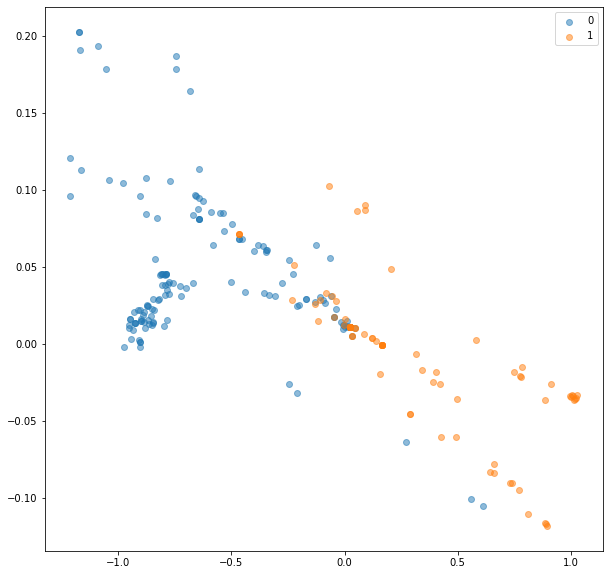

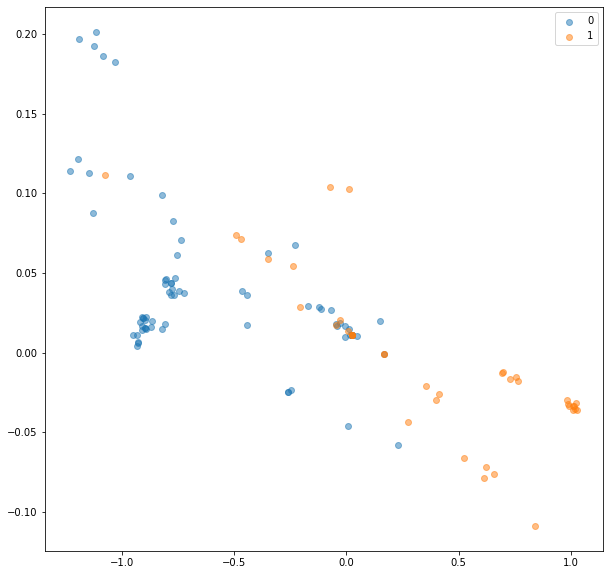

In [104]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(val_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)